### Lập trình hồi quy Softmax từ đầu
- Hồi quy softmax hay hồi quy logistic đa lớp là một kỹ thuật căn bản mà ta cần hiểu biết tường tận các chi tiết để có thể xây dựng lại. Sau khi tự lập trình lại mọi thứ thì ta nên dùng Gluon để so sánh.

In [154]:
from d2l import mxnet as d2l
from mxnet import autograd, np, npx, gluon
from IPython import display
npx.set_np()

In [155]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

#### Khởi tạo các tham số của mô hình
- Như hồi quy tuyến tính, mỗi mẫu sẽ được biểu diễn bằng một vector có chiều dàu cố định. Mỗi mẫu trong tập dữ liệu thô là một ảnh 28 x 28. Trong phần này, chúng ta sẽ trải phẳng tấm ảnh thành một vector có kích thước là 784, coi như mỗi điểm ảnh là một đặc trưng.
- Nhắc lại trong hồi quy softmax, mỗi lớp sẽ có một đầu ra. Vì tập dữ liệu của ta có 10 lớp, mạng của ta sẽ có 10 đầu ra. Do đó, các trọng số sẽ tạo thành một ma trận 784 x 10 và các hệ số điều chỉnh tạo thành một vector 1 x 10. Cũng như hồi quy tyến tính, ta sẽ khởi tạo trọng số W bằng nhiều Gauss và các hệ số điều chỉnh được khởi tạo bằng 0.

In [156]:
num_inputs = 784
num_outputs = 10

W = np.random.normal(0, 0.01, (num_inputs, num_outputs))
b = np.zeros(num_outputs)

# Đính kém gradient vào các tham số của mô hình
W.attach_grad()
b.attach_grad()

#### Softmax
- Ôn lại tác dụng của toán tử như sum trên những chiều cụ thể của một ndarray. 
    1. Cho một ma trận X, ta có thẻ tính tổng các phần tử (mặc định) hoặc chỉ trên các phần tử trong cùng một trục.
    2. Ví dụ như cột axis = 0 hoặc cùng hàng (axis = 1). 
    3. Lưu ý rằng nếu X là mảng có kích thước là (2, 3), tính tổng các cột (X.sum(axis = 0)) thì sẽ trả về một vector một chiều có kích thước là (3, ). 4. Nếu ta muốn giữ số lượng trục như mảng ban đầu thay vì đã tính toán (1, 3) thì ta có thể chỉ định ***'keepdims = True'*** khi gọi hàm sum.

In [157]:
X = np.array([[1, 2, 3], [5, 6, 7]])
print(X.sum(axis = 0, keepdims=True))
print(X.sum(axis = 0, keepdims=False))
print(X.sum(axis = 1, keepdims=True))

[[ 6.  8. 10.]]
[ 6.  8. 10.]
[[ 6.]
 [18.]]


Việc tính hàm softmax bao gồm hai bước. Đầu tiên, ta lũy thừa từng giá trị sử dụng hàm exp. Sau đó tính tổng trên mỗi hàng để lấy hằng số chuẩn hóa cho mỗi mẫu vì mỗi mẫu là một hàng. Cuối cùng, chia mỗi hàng theo hằng số chuẩn hóa của nó để đảm bảo rằng tổng các phần tử trong cùng một hàng có kết quả bằng 1. 
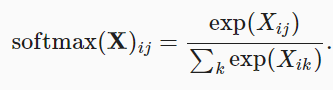

In [158]:
def softmax(X):
    X_exp = np.exp(X)
    partition = X_exp.sum(axis = 1, keepdims=True)
    return X_exp/partition 

X = np.random.normal(size= (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis = 1)

(array([[0.14777744, 0.04510869, 0.40290928, 0.16903862, 0.23516594],
        [0.07681053, 0.5997059 , 0.11494506, 0.14536881, 0.06316968]]),
 array([0.99999994, 0.99999994]))

#### Mô hình
- Sau khi đã định nghĩa hàm softmax, ta bắt đầu lập trình hồi quy softmax. 
- Đoạn mã sau định nghĩa lượt truyền xuôi qua mạng, chú ý tằng ta sẽ làm phẳng mỗi ảnh gốc trên batch thành một vector có độ dài num_inputs bằng hàm reshape trước khi truyền dữ liệu sang mô hình đã khởi tạo.

In [159]:
def net(X):
    return softmax(np.dot(X.reshape(-1, num_inputs), W) + b)

#### Hàm loss
- Ta cần lập trình hàm entropy chéo. Đây là hàm loss thông dụng nhất trong phần lớn nghiên cứu về học sâu do số lượng các bài toán phân loại nhiều hơn số lượng bài toán hồi quy.
- Nhắc lại rằng hàm entropy chéo lấy đầu vào là đối log hợp lý của xác suất dự đoán được gán cho nhãn thật -logP(y|x). Thay vì lặp qua các dữ đoán của mô hình thì ta sử dụng chỉ mục nầng cao của NumPy.
- Ta sẽ đưa vào hai danh sách, danh sách đầu tiên là chỉ số hàng và danh sách thứ hai là chỉ mục cột.
- Ví dụ y_hat[[0, 1], [0, 2]] sẽ truy xuất hai phần tử (0, 0) và (1, 2).
- Ứng dụng vào bài toán, ta sẽ lấy chỉ số các hàng bằng cách sử dụng range(len(y_hat)) làm danh sách hàng và lấy y là danh sách các chỉ số cột.

In [160]:
y_hat = np.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], [0, 2]]

array([0.1, 0.5])

In [161]:
def cross_entropy(y_hat, y):
    return - np.log(y_hat[range(len(y_hat)), y])

#### Độ chính xác cho bài toán phân loại
- Với phân phối xác suất dự đoán y_hat, ta thường chọn lớp có xác suất dự đoán cao nhất khi phải đưa ra một dự đoán cụ thể. 
- Các dự đoán được coi là chính xác khi chúng khớp với lớp thực tế y. Độ chính xác phân loại được tính bởi tỷ lệ các dự đoán chính xác trên tất cả các dự đoán đã đưa ra. Dù ta có thể gặp khó khăn khi tối ưu hóa trực tiếp độ chính xác (do chúng không khả vi), đây thường là phép đo chất lượng được quan tâm nhiều nhất và sẽ luôn được tính khi huấn luyện các bộ phân loại.
- Độ chính xác được tính toán như sau: 
    1. Sử dụng y_hat.argmax(axis = 1) nhằm lấy ra các lớp được dự đoán hay chỉ số của phần tử lớn nhất trên mỗi hàng. Kết quả trả về sẽ cùng kích thước với y.
    2. Do y có kiểu int, y_hat có kiểu float32 nên cần phải cast y về float32. 3. So sánh sử dụng toán tử '=='

In [162]:
def accuracy(y_hat, y):
    if y_hat.shape[1] > 1:
        return float((y_hat.argmax(axis = 1) == y.astype('float32')).sum())
    else:
        return float((y_hat.astype('int') == y.astype('int')).sum())

y = np.array([0, 2])
y_hat = np.array([[0.6, 0.2, 0.2], [0.2, 0.5, 0.3]])
print(accuracy(y_hat, y) / len(y))

0.5


Tương tự ta có thể đánh giá độ chính xác của mô hình net trên tập dữ liệu.

In [163]:
def evaluate_accuracy(net, data_iter):
    total = 0
    correct = 0
    for X, y in data_iter:
        total += len(y)
        correct += accuracy(net(X), y)
    return float(correct)/total

evaluate_accuracy(net, test_iter)

0.0892

### Thiết lập các class phụ trợ

In [164]:
class Accumulator(object):
    """Sum a list of numbers over time"""
    def __init__(self, n):
        self.data = [0.0] * n

    """
        Ví dụ: 
        acc = Accumulator(3)  
        print(acc.data)  # Output: [0.0, 0.0, 0.0]
        Lớp này hiện có thể lưu trữ 3 giá trị tích lũy riêng biệt.
    """
    def add(self, *arg):
        self.data = [a + float(b) for a, b in zip(self.data, arg)]
        # for i in range(min(len(self.data), len(arg))):
        #     self.data[i] += float(arg[i])
    """
        *args cho phép truyền nhiều số vào cùng lúc
        Dùng vòng lặp zip(self.data, args) để cộng từng phần tử b vào giá trị tương ứng a trong self.data
    """
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, i):
        if (i >= len(self.data) or i < 0): 
            return 0
        else :
            return self.data[i] 

# Example
metrics = Accumulator(2)
metrics.add(10, 10)
metrics.add(1, 2)
print(metrics.__getitem__(0), metrics.__getitem__(1), metrics.__getitem__(2))
metrics.reset()
print(metrics.__getitem__(0), metrics.__getitem__(1), metrics.__getitem__(2))


11.0 12.0 0
0.0 0.0 0


In [165]:
"""
    xlabel, ylabel: Nhãn của trục X và Y
    legend: Danh sách chứa các nhãn chú thích (labels) cho từng đường trong đồ thị
    xlim, ylim: giới hạn của trục X và Y
    xscale, yscale: Kiểu tỷ lệ của trục X và Y, mặc định là linear, có thể là log
    fmts: Định dạng dòng vẽ, ví dụ ['-', '--', 'o'] cho đường liền, đường gạch và dấu tròn
    nrows, ncols: Số hàng và số cột của lưới của đồ thị (subplot)
    figsize: kích thước hình ảnh
"""
class Animator(object):
    def __init__(self, xlabel = None, ylabel = None, legend = [], xlim = None, ylim = None,
                 xscale = 'linear', yscale = 'linear', fmts = None, 
                 nrows = 1, ncols = 1, figsize = (3.5, 2.5)):
        """Incrementally plot multiple lines."""
        d2l.use_svg_display()

        # Tạo một figure chứa nhiều subplot
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize = figsize)
        
        # Nếu chỉ có một subplot thì self.axes là một đối tượng AxesSubplot, không phải danh sách, cần chuyển thành danh sách [self.axes, ] để đồng nhất cách truy cập
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        
        # self.congif_axes là một hàm lambda (hàm ẩn danh) dùng để thiết lập các thuộc tính cho trục đầu tiên self.axes[0]
        self.config_axes = lambda: d2l.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

        # Lưu trữ dữ liệu X, Y và định dạng dòng
        self.X, self.Y, self.fmts = None, None, fmts

    """
        Hàm thêm dữ liệu vào đồ thị
    """
    def add(self, x, y):
        # Nếu x hay y là một số đơn thì biến nó thành danh sách
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x]

        # Nếu self.X hay self.Y chưa được khởi tạo thì ta tạo danh sách rỗng cho từng đường
        # với n là số đường
        if self.X is None:
            self.X = [[] for _ in range(n)]
        if self.Y is None:
            self.Y = [[] for _ in range(n)]

        # Nếu self.fmts chưa được khởi tạo thì ta đặt mặc định là '-'
        if self.fmts is None:
            self.fmts = ['-'] * n
        
        # Cập nhật dữ liệu mới vào danh sách self.X, self.Y
        # Mỗi lần gọi hàm này thì sẽ thêm một điểm vào mỗi đường
        for i, (a, b) in enumerate(zip(x, y)):
            if (a is not None and b is not None):
                print(i, a, b)
                self.X[i].append(a)
                self.Y[i].append(b)
            
        
        # Xóa và vẽ lại đồ thị để tránh vẽ chồng lên nhau
        self.axes[0].cla()

        # Vẽ từng đường trên đồ thị
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        
        # Cấu hình trục và hiển thị
        self.config_axes() # Cập nhật cài đặt trục
        display.display(self.fig) # Hiển thị lại đồ thị
        display.clear_output(wait=True) # Xóa đầu ra cũ để làm mới -> giúp hiển thị liên tục mà không bị nhấp nháy
    
    def getX(self):
        return self.X
    def getY(self):
        return self.Y

#### Huấn luyện mô hình
- Hàm huấn luyện sẽ chạy qua nhiều epoch và trực quạn hóa quá trình huấn luyện.

In [166]:
"""
    Updater là hàm tổng quát để cập nhật tham số của mô hình và sẽ nhận kích thước batch làm đối số
    Nó có thể là một wrapper của d2l.sgd hoặc là một đối tượng huấn luyện gluon.
"""
def train_epoch(net, train_iter, loss, updater):
    # train_los_sum, train_acc_sum, num_examples
    metric = Accumulator(3)

    if isinstance(updater, gluon.Trainer):
        updater = updater.step
    
    for X, y in train_iter:
        with autograd.record():
            y_hat = net(X)
            l = loss(y_hat, y)
        l.backward()
        updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.size)
    
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [167]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel = 'epoch', xlim = [1, num_epochs], 
                        ylim = [0.3, 0.9], legend = ['train_loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        ypoints = [train_metrics[0], train_metrics[1], test_acc]
        animator.add([epoch + 1] * len(ypoints), ypoints)

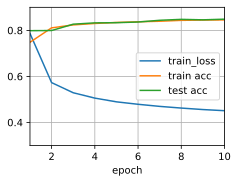

In [169]:
num_epochs, lr = 10, 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

train(net, train_iter, test_iter, cross_entropy, num_epochs, updater)


In [170]:
evaluate_accuracy(net, test_iter)

0.8487

### Dự đoán
- Ta sử dụng mô hình vừa train được để phân loại 18 ảnh trong bộ dữ liệu test

array([<AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'coat'}>,
       <AxesSubplot:title={'center':'shirt'}>,
       <AxesSubplot:title={'center':'bag'}>,
       <AxesSubplot:title={'center':'shirt'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'coat'}>,
       <AxesSubplot:title={'center':'coat'}>,
       <AxesSubplot:title={'center':'coat'}>,
       <AxesSubplot:title={'center':'bag'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'coat'}>,
       <AxesSubplot:title={'center':'dress'}>], dtype=object)

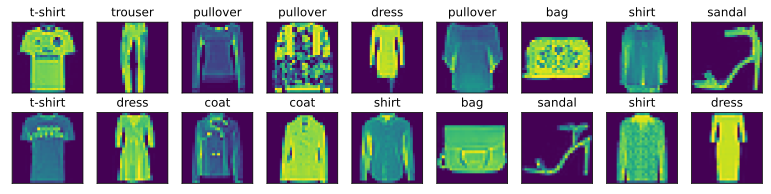

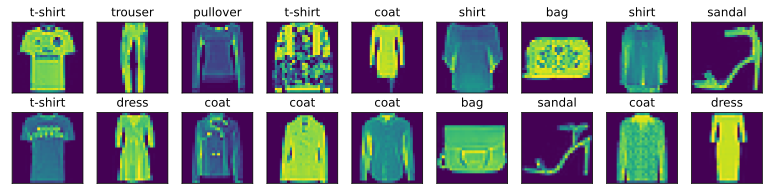

In [182]:
def show_images(imgs, num_rows, num_cols, titles = None, scale = 1.5):
    figsize = (num_cols * scale, num_rows * scale)

    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize = figsize)

    axes = axes.flatten()
    
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles is not None:
            ax.set_title(titles[i])
    return axes

for X, y in test_iter:
    break
images = X.squeeze(1)
show_images(images, 2, 9, titles = d2l.get_fashion_mnist_labels(y))
y_hat = net(X)
show_images(images, 2, 9, titles = d2l.get_fashion_mnist_labels(y_hat.argmax(axis = 1)))